In [128]:
%matplotlib inline
import sys
print(sys.version)

import numpy as np
print 'Numpy version:', np.__version__

import pandas as pd
print 'Pandas version:', pd.__version__

import matplotlib as mpl
import matplotlib.pyplot as plt
print 'Matplotlib version:', mpl.__version__

import seaborn as sns
print 'Seaborn version:', sns.__version__

import datetime
import time

sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

pd.set_option('display.float_format', lambda x: '%.4f' % x)

2.7.13 |Anaconda 4.0.0 (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Numpy version: 1.11.2
Pandas version: 0.19.2
Matplotlib version: 1.5.3
Seaborn version: 0.6.0


In [2]:
df_uber = pd.read_csv('Data/uber_nyc_data.csv')

In [3]:
df_uber.info() #near 31 million entries, ~1.4GB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
id                 int64
origin_taz         object
destination_taz    object
pickup_datetime    object
trip_distance      float64
trip_duration      object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [4]:
df_uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17


In [5]:
#The ID is unique
len(df_uber.id.unique())

30925738

In [6]:
#There are no duplicated rows (this takes a while to run):
len(df_uber[df_uber.duplicated() == True])

0

In [11]:
#Check some of the data with missing destination. 
#One idea to fill missing values would be predict destination based on the other features.
df_uber[df_uber.destination_taz.isnull()].head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15,252596,6B,NaN,2014-09-01 17:00:00,11.67,0:23:45
32,252613,9,NaN,2014-09-01 16:00:00,80.69,1:59:37
63,252644,9,NaN,2014-09-01 18:00:00,23.07,1:03:37
141,252722,9,NaN,2014-09-01 10:00:00,21.73,0:41:12
148,252729,4B,NaN,2014-09-01 10:00:00,4.62,0:14:55


In [12]:
#There are 38 records with values missing for trip distance and duration, none of which are missing the destination.
df38 = df_uber[df_uber.trip_duration.isnull() & df_uber.trip_distance.isnull()]
df38.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15155317,39535,2A,11,2015-04-25 12:00:00,NaN,NaN
15245057,1009076,2A,2A,2015-04-26 01:00:00,NaN,NaN
16519652,15028665,2A,7C,2015-04-29 21:00:00,NaN,NaN
17148253,22250173,2A,2A,2015-04-12 02:00:00,NaN,NaN
17297563,23716998,2C,11,2015-04-25 13:00:00,NaN,NaN


## Parse the pickup_datetime column to datetime type and create related features.

In [18]:
#Drop repeated column
df_uber = df_uber.drop('pickup_datetime', axis=1)

### Get the federal holidays for the period (useful for analyzing data later)

In [19]:
#Get all federal holidays in the period
from pandas.tseries.holiday import USFederalHolidayCalendar

#if return_name is True, then name is series value and date is the series index, otherwise date is series value.
holidays = USFederalHolidayCalendar().holidays(beginning, end, return_name = True) 
holidays

2014-09-01                     Labor Day
2014-10-13                  Columbus Day
2014-11-11                  Veterans Day
2014-11-27                  Thanksgiving
2014-12-25                     Christmas
2015-01-01                 New Years Day
2015-01-19    Dr. Martin Luther King Jr.
2015-02-16                Presidents Day
2015-05-25                   MemorialDay
2015-07-03                      July 4th
dtype: object

In [21]:
#For completeness, let's add the day before and after the holidays (better: add day after if Thursday)
holidays_all = pd.concat([holidays, "Day After " + holidays.shift(1, 'D'), "Day Before " + holidays.shift(-1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head(10)

2014-08-31       Day Before Labor Day
2014-09-01                  Labor Day
2014-09-02        Day After Labor Day
2014-10-12    Day Before Columbus Day
2014-10-13               Columbus Day
2014-10-14     Day After Columbus Day
2014-11-10    Day Before Veterans Day
2014-11-11               Veterans Day
2014-11-12     Day After Veterans Day
2014-11-26    Day Before Thanksgiving
dtype: object

### Create other date and time features.

In [22]:
#Create a column with the date, without the time. This will be useful later.
t0 = time.time()
df_uber['pu_date'] = pd.Series(map(lambda x: x.astype('datetime64[D]'), df_uber['pu_date_hour'].values))
#df_uber['pu_date'] = df_uber['pu_date_hour'].dt.date #this is way less memory effective and 11 sec slower to execute
time.time() - t0

58.91848111152649

In [23]:
#Get month and year from pick up timestamp
df_uber['year'] = df_uber['pu_date_hour'].dt.year
df_uber['month'] = df_uber['pu_date_hour'].dt.month

In [24]:
#Get trip pick up day of the month
t0 = time.time()
df_uber['day'] = df_uber['pu_date_hour'].dt.day #.apply(lambda x: x.day) = 105 seconds vs < 2 seconds with dt
time.time() - t0

1.7083799839019775

In [25]:
#Get trip pick up hour from timestamp
t0 = time.time()
df_uber['hour'] = df_uber['pu_date_hour'].dt.hour #< 2 seconds vs 101 seconds using apply lambda
time.time() - t0

1.882817029953003

In [26]:
#Get trip pick up weekday from timestamp
t0 = time.time()
df_uber['weekday'] = df_uber['pu_date_hour'].dt.dayofweek
time.time() - t0

2.0246660709381104

In [27]:
df_uber.weekday.value_counts() #Monday = 0, Sunday = 6

5    5142832
4    4805002
3    4625511
6    4331195
2    4301537
1    4010434
0    3709227
Name: weekday, dtype: int64

In [28]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday
0,252581,7C,6A,4.25,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0
1,252582,7B,15,10.17,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0
2,252583,11,2A,4.02,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0
3,252584,3B,4A,1.46,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0
4,252585,2A,10,8.31,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0


In [29]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 12 columns):
id                 int64
origin_taz         object
destination_taz    object
trip_distance      float64
trip_duration      object
pu_date_hour       datetime64[ns]
pu_date            datetime64[ns]
year               int64
month              int64
day                int64
hour               int64
weekday            int64
dtypes: datetime64[ns](2), float64(1), int64(6), object(3)
memory usage: 2.8+ GB


## Transform trip duration data.

In [30]:
uniq_dur = df_uber[df_uber.trip_duration.isnull() == False].trip_duration.unique() #19393

In [31]:
#Among unique duration strings, find how many represent >= 10h of duration:
long_duration = [] #>= 10 hours or 600 minutes
for item in uniq_dur:
    if len(item) != 7:
        long_duration.append(item)

#long_duration
print len(long_duration)

386


In [32]:
#Check for the most unusual strings for trip duration: some erroneous entries need to be addressed
for item in long_duration:
    if len(item) > 8:
        print item

172032:14:50
172032:39:03
136:25:12
172032:17:45
172032:19:27
119:53:35
120:49:05


In [33]:
def duration_to_minutes(s):
    """
    Function that takes a string with the hh:mm:ss format and
    returns the integer equivalent of the total time in minutes, 
    or zero for missing values in a Pandas dataframe.
    """
    if pd.isnull(s):
        val = 0 #note: this fills with 0 the 38 instances with null (missing) values
    else:
        hms = s.split(':')
        val = int(hms[0])*60 + int(hms[1]) + int(hms[2])/60.0
    return val

In [34]:
#Transform the trip duration string into trip duration in minutes:
t0 = time.time()
df_uber['duration_min'] = df_uber.trip_duration.apply(duration_to_minutes) 
time.time() - t0

88.3189799785614

In [35]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min
0,252581,7C,6A,4.25,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0,15.183333
1,252582,7B,15,10.17,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0,34.083333
2,252583,11,2A,4.02,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0,17.100000
3,252584,3B,4A,1.46,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0,6.533333
4,252585,2A,10,8.31,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0,26.283333


## Calculate Estimated Revenue per Trip.

In [42]:
#Source: http://uberestimate.com/prices/New-York-City/ for Uber X
base_fare = 2.55
per_minute = 0.35
per_mile = 1.75
min_fare = 8

In [46]:
#Using eval() is even more efficient for large datasets than resorting to Numpy! 
#Local variables must be followed by @. Only for arithmetic, cannot use if statement, for example.
df_uber['est_revenue'] = df_uber.eval('@base_fare + duration_min * @per_minute + trip_distance * @per_mile')
df_uber.loc[df_uber.est_revenue < 8, 'est_revenue'] = min_fare

In [47]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
0,252581,7C,6A,4.25,2014-09-01,2014,9,1,9,0,15.183333,16.794731,15.301667
1,252582,7B,15,10.17,2014-09-01,2014,9,1,18,0,34.083333,17.903178,32.276667
2,252583,11,2A,4.02,2014-09-01,2014,9,1,17,0,17.100000,14.105263,15.570000
3,252584,3B,4A,1.46,2014-09-01,2014,9,1,13,0,6.533333,13.408163,8.000000
4,252585,2A,10,8.31,2014-09-01,2014,9,1,14,0,26.283333,18.970197,26.291667


## Visualizing the demand: number of Uber trips per day.

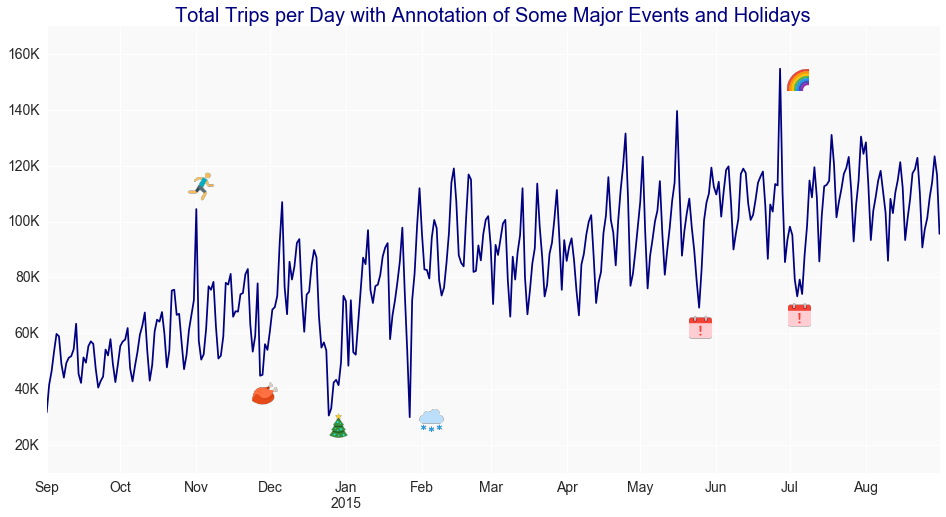

In [238]:
#Create a plot with the total number of trips per day, highlighting some changepoints associated with major holidays 
#and other weather and touristic/cultural events.

fig = plt.figure()

ax = byDate.plot(figsize = (16, 8), fontsize = 12, ylim = (10000, 170000), color = 'navy')

formatter = FuncFormatter(thousands_format)
ax.yaxis.set_major_formatter(formatter)
ax.set_axis_bgcolor('#F9F9F9') #make background color a lighter gray to better contrast with the icon's images.

plt.title('Total Trips per Day with Annotation of Some Major Events and Holidays', fontsize= 20, color='navy')
plt.tick_params(labelsize=14)
plt.xlabel('')


#Add icon to indicate snowstorm on the plot:
#NYC's mayor ordered the city under curfew, and public transportation system was shut down late on 1/26/15.
img1 = read_png('Data/icons/Snow-48.png')
imagebox = OffsetImage(img1, zoom=0.6)
xy = ['2015-01-27', 25000] # (len(byDate[:'2015-01-27'])-1, byDate['2015-01-27'])

ab = AnnotationBbox(imagebox, xy, 
                    xybox=(22., 10.), #position from xy to lower left corner of box
                    xycoords='data', #will use data coordinates for x and y
                    boxcoords='offset points', #same idea as textcoords, in points from lower left corner
                    pad=0.1, frameon=False) #padding around the image
ax.add_artist(ab)


#Add icon to indicate Thanksgiving on the plot:
img2 = read_png('Data/icons/Thanksgiving-48.png')
imagebox = OffsetImage(img2, zoom=0.6) 
xy = ['2014-11-27', 40000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Christmas on the plot:
img2 = read_png('Data/icons/Christmas Tree-48.png')
imagebox = OffsetImage(img2, zoom=0.6) 
xy = ['2014-12-25', 25000] 
ab = AnnotationBbox(imagebox, xy, xybox=(10., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Memorial Day Holiday on the plot:
img3 = read_png('Data/icons/Leave-48.png')
imagebox = OffsetImage(img3, zoom=0.6) 
xy = ['2015-05-25', 60000] 
ab = AnnotationBbox(imagebox, xy, xybox=(1., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Pride Week on the plot:
#According to The Wall Street Journal, the Pride Parade was attended by 1.6 million people in 2015.
img4 = read_png('Data/icons/Rainbow-48.png')
imagebox = OffsetImage(img4, zoom=0.6) 
xy = ['2015-06-27', 150000] 
ab = AnnotationBbox(imagebox, xy, xybox=(18., 2.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Independence Day Holiday on the plot:
img5 = read_png('Data/icons/Leave-48.png')
imagebox = OffsetImage(img5, zoom=0.6) 
xy = ['2015-07-03', 70000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -10.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate NYC Marathon event on the plot:
img5 = read_png('Data/icons/Running-48.png')
imagebox = OffsetImage(img5, zoom=0.7) 
xy = ['2014-11-01', 110000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., 7.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

plt.show()
#plot_url = py.plot_mpl(fig)

## The effect of time on demand for Uber rides: distribution per hour, weekday, and month.

In [64]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

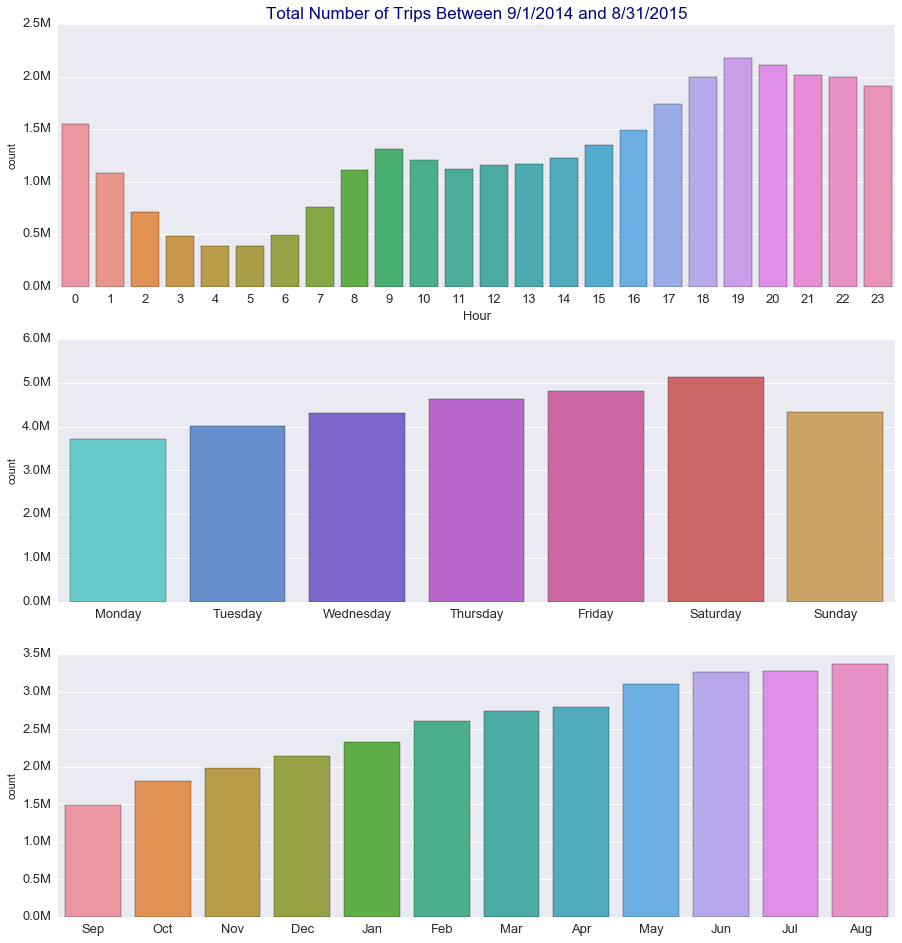

In [286]:
# Create plots comparing demand per different time categories:
fig = plt.figure(figsize = (15,16))
formatter = FuncFormatter(millions_format)

plt.subplot(3,1,1) #this plot could have a polar format, although I'm not sure it'd be a better viz.
ax1 = sns.countplot(df_viz.hour, order = range(24))
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.title('Total Number of Trips Between 9/1/2014 and 8/31/2015', fontsize=17, color='navy')
plt.xlabel('Hour', fontsize=13)

plt.subplot(3,1,2)
ax2 = sns.countplot(df_viz.weekday, order = range(7))
ax2.set_xticklabels(weekday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.subplot(3,1,3) #same as the line plot but with less granularity, perhaps easier to visualize the MOM growth
ax3 = sns.countplot(df_viz.month)
ax3.set_xticklabels(month_labels)
ax3.yaxis.set_major_formatter(formatter)
#plt.text(0, 3100000, 'Consistent growth in the number of trips from month to month!', color='navy', size=15)
plt.tick_params(labelsize=13)
plt.xlabel('')

#fig.subplots_adjust(hspace=.5)
plt.show()

## Estimated Monthly Base Revenue: how much was the NYC market worth in the period?

In [66]:
#Create dataframe with grouped revenue data:
byDateRev = df_viz.groupby('month')['est_revenue'].sum()

In [67]:
#Estimate Uber's gross margin for the entire 1 year period based on 25% share of the base revenue.
sumRev = byDateRev.sum()
print '${:,.0f}M'.format(sumRev * 1e-6), "Base Revenue   Uber's Base Gross Margin:", '${:,.0f}'.format(sumRev * .25)

$595M Base Revenue   Uber's Base Gross Margin: $148,757,755


In [312]:
#Estimated base gross margin based on information that average UberX fare in Sep 2014 was $27 (but it has dropped):
len(df_viz) * 27 * .25

208735400.25

In [68]:
byDateRev.head()

month
1    4.145715e+07
2    4.725285e+07
3    5.215439e+07
4    5.409507e+07
5    6.153991e+07
Name: est_revenue, dtype: float64

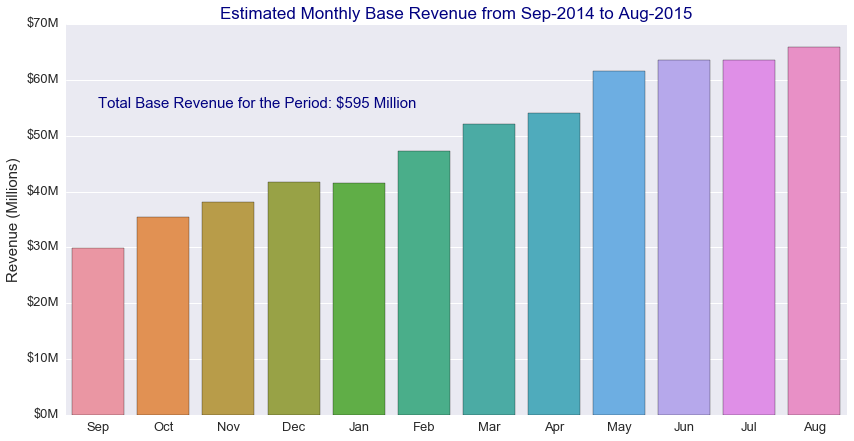

In [284]:
#Create chart showing total base revenue per month.
months_seq = [9,10,11,12,1,2,3,4,5,6,7,8]
formatter = FuncFormatter(millions_currency)

plt.figure(figsize = (14, 7))
ax = sns.barplot(byDateRev.index, byDateRev.values, order = months_seq)
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

font = {'color': 'navy', 'size': 15} #text parameters
plt.text(0, 55000000, 'Total Base Revenue for the Period: ${:,.0f} Million'.format(sumRev * 1e-6), 
         fontdict = font) #params: x, y, text, fontdict
plt.xlabel('')
plt.ylabel('Revenue (Millions)', fontsize = 15)
plt.tick_params(labelsize=13)
plt.title('Estimated Monthly Base Revenue from Sep-2014 to Aug-2015', fontsize = 17, color='navy')

plt.show()

In [310]:
#Mean fare from revenue estimate for the period: $19.24 (assumes all trips are Uber X)
df_viz.est_revenue.mean()

19.241869694747738

In [306]:
#Rough estimate of revenue share from Uber Pool from 12/1/2014 to 8/31/2015 (total of 25,634,526 trips):
rev = df_viz[(df_viz.pu_date >= datetime.date(2014, 12, 1)) & (df_viz.pu_date <= datetime.date(2015, 8, 31))]\
.est_revenue.mean() #$19.17 mean revenue

u_pool = rev * 0.75 * 1500000
u_pool #$21,565,512 estimated revenue

21565512.055648196

In [309]:
u_pool/df_viz[(df_viz.pu_date >= datetime.date(2014, 12, 1)) & (df_viz.pu_date <= datetime.date(2015, 8, 31))]\
.est_revenue.sum() #Uber Pool represented only about 4% of the total revenue for the period between Dec/14 and Aug/15.

0.04388612451815961

## Join Weather Data.

In [106]:
#Weather Data Key (Central Park, NYC Station):
#PRCP = precipitation in inches
#SNWD = snow depth in inches
#SNOW = snowfall in inches
#TMAX = max temperature in F (minimum of 2F for entire period from 2014 to 2015)
#TMIN = min temperature in F (maximum of 97F for the entire period from 2014 to 2015)
#AWND = average daily wind speed in MPH

In [107]:
#Refer to data source. Use integrated weather data to forecast demand for rides.
weather = pd.read_csv('Data/weather.csv', na_values = -9999, parse_dates = ['DATE'], \
                      usecols = [u'DATE', u'PRCP', u'SNWD', u'SNOW', u'TMAX', u'TMIN', u'AWND'])

In [108]:
weather.columns = ['pu_date', 'prcp', 'snwd', 'snow', 'tmax', 'tmin', 'awnd']
weather.head()

,pu_date,prcp,snwd,snow,tmax,tmin,awnd
0,2014-01-01,0.00,0.0,0.0,33,24,5.6
1,2014-01-02,0.33,0.0,3.1,33,18,12.3
2,2014-01-03,0.29,5.9,3.3,18,9,10.5
3,2014-01-04,0.00,5.9,0.0,29,8,4.9
4,2014-01-05,0.14,3.9,0.0,40,27,3.8


In [109]:
#There are some nan missing values for wind speed:
weather.awnd[24:27]

24    7.6
25    NaN
26    7.8
Name: awnd, dtype: float64

In [110]:
#Merge weather data
#avoiding unncessary sorting by key improves perfomance
df_merged = pd.merge(df_uber, weather, on='pu_date', how='left', sort=False)

In [111]:
df_merged.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue,prcp,snwd,snow,tmax,tmin,awnd
0,252581,7C,6A,4.25,2014-09-01,2014,9,1,9,0,15.183333,16.794731,15.301667,0.0,0.0,0.0,88,75,2.9
1,252582,7B,15,10.17,2014-09-01,2014,9,1,18,0,34.083333,17.903178,32.276667,0.0,0.0,0.0,88,75,2.9
2,252583,11,2A,4.02,2014-09-01,2014,9,1,17,0,17.100000,14.105263,15.570000,0.0,0.0,0.0,88,75,2.9
3,252584,3B,4A,1.46,2014-09-01,2014,9,1,13,0,6.533333,13.408163,8.000000,0.0,0.0,0.0,88,75,2.9
4,252585,2A,10,8.31,2014-09-01,2014,9,1,14,0,26.283333,18.970197,26.291667,0.0,0.0,0.0,88,75,2.9


In [112]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30925738 entries, 0 to 30925737
Data columns (total 19 columns):
id                 int64
origin_taz         object
destination_taz    object
trip_distance      float64
pu_date            datetime64[ns]
year               int64
month              int64
day                int64
hour               int64
weekday            int64
duration_min       float64
trip_mph_avg       float64
est_revenue        float64
prcp               float64
snwd               float64
snow               float64
tmax               int64
tmin               int64
awnd               float64
dtypes: datetime64[ns](1), float64(8), int64(8), object(2)
memory usage: 4.6+ GB
